<a href="https://colab.research.google.com/github/mak372/Tweet-emotion-recognition/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


## Task 2: Setup and Imports



In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 7.2 MB/s 
     |████████████████████████████████| 243 kB 74.2 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Task 3: Importing Data



In [ ]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
train = dataset['train']
test = dataset['test']
val = dataset['validation']

In [ ]:
def get_tweets(data):
  tweet = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweet,labels

In [ ]:
tweet,labels = get_tweets(train)

In [ ]:
tweet[2],labels[2]

('im grabbing a minute to post i feel greedy wrong', 'anger')

## Task 4: Tokenizer



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
token = Tokenizer(num_words=10000,oov_token='<UNK>')
token.fit_on_texts(tweet)

## Task 5: Padding and Truncating Sequences



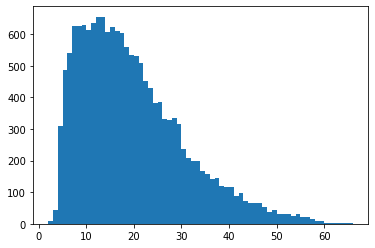

In [ ]:
lengths = [len(t.split(' ')) for t in tweet]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(token,tweet):
  sequences = token.texts_to_sequences(tweet)
  padding = pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padding

In [ ]:
padding_train = get_sequences(token,tweet)

In [ ]:
padding_train[2]

array([  17, 3060,    7, 1149,    5,  286,    2,    3,  495,  438,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Task 6: Preparing the Labels



In [ ]:
classes = set(labels)
print(classes)

{'fear', 'anger', 'sadness', 'love', 'joy', 'surprise'}


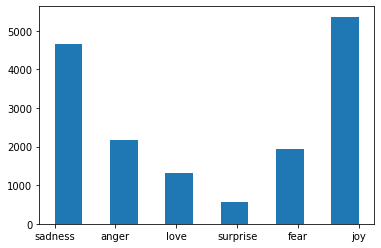

In [ ]:
plt.hist(labels,bins=11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 1, 'fear': 0, 'joy': 4, 'love': 3, 'sadness': 2, 'surprise': 5}

In [ ]:
index_to_class

{0: 'fear', 1: 'anger', 2: 'sadness', 3: 'love', 4: 'joy', 5: 'surprise'}

In [ ]:
name_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = name_to_ids(labels)
print(train_labels[2])

1


## Task 7: Creating the Model



In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6,activation="softmax")
                                  ])
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model



In [ ]:
val_tweet,val_labels = get_tweets(val)
val_seq = get_sequences(token,val_tweet)
val_labels = name_to_ids(val_labels)

In [ ]:
val_tweet[0],val_labels[0]


('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [ ]:
h = model.fit(
    padding_train,train_labels,
    validation_data = (val_seq,val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)]
)

Epoch 1/20
500/500 [==============================] - 19s 17ms/step - loss: 1.3798 - accuracy: 0.3966 - val_loss: 1.0864 - val_accuracy: 0.5635
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.6723 - accuracy: 0.7376 - val_loss: 0.6260 - val_accuracy: 0.7710
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3894 - accuracy: 0.8696 - val_loss: 0.4924 - val_accuracy: 0.8445
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2658 - accuracy: 0.9119 - val_loss: 0.4612 - val_accuracy: 0.8545
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2027 - accuracy: 0.9310 - val_loss: 0.4199 - val_accuracy: 0.8695
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1576 - accuracy: 0.9498 - val_loss: 0.3992 - val_accuracy: 0.8735
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1259 - accuracy: 0.9596 - val_loss: 0.3990 - val_accuracy: 0.886

## Task 9: Evaluating the Model



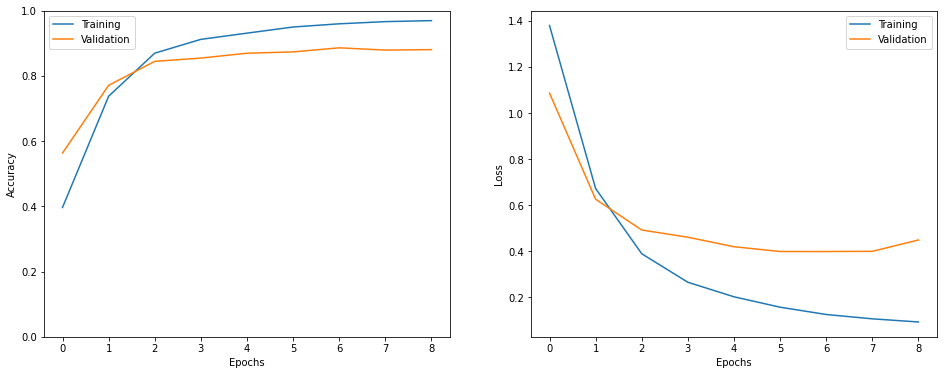

In [ ]:
show_history(h)

In [ ]:
test_tweet,test_labels = get_tweets(test)
test_seq = get_sequences(token,test_tweet)
test_labels = name_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4410 - accuracy: 0.8815


In [ ]:
i = random.randint(0,len(test_labels)-1)
print("Sentence:",test_tweet[i])
print("Emotion:",index_to_class[test_labels[i]])

prediction = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(prediction).astype('uint8')]
print("Prediction:",pred_class)

Sentence: i feel betrayed and angry and sad at the same time dammit
Emotion: anger
Prediction: sadness


In [ ]:
pred = model.predict_classes(test_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


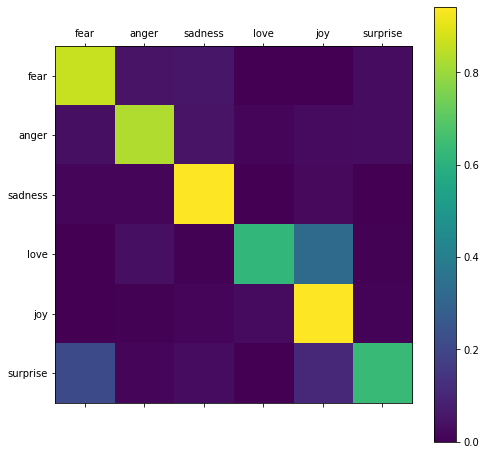

In [ ]:
show_confusion_matrix(test_labels,pred,list(classes))